In [1]:
import sys
sys.path.append('../src/')
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment
import random
import torch
import pandas as pd
from tqdm import tqdm
from corpus import Corpus
from models import GTM
from simulations import generate_documents
from joblib import Parallel, delayed
import numpy as np

num_docs = 10000
num_topics = 6
vocab_size = 500
min_words = 1000
max_words = 1000
num_covs = 0
doc_topic_prior = 'logistic_normal'

# ----- Simulate data -----

df_true_dist_list_gtm, df, topic_word_matrices, lambda_, label_coeffs = generate_documents(
    num_docs,
    num_topics,
    vocab_size,
    doc_topic_prior='logistic_normal',
    min_words=min_words,
    max_words=min_words,
    random_seed=42
)  

In [2]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()  
vectorizer.fit(df["doc_clean_0"])

modalities = {
    "text": {
        "column": "doc_clean_0",
        "views": {
            "bow": {
                "type": "bow",
                "vectorizer": vectorizer
            }
        }
    }
}

full_dataset = Corpus(
    df,
    modalities=modalities
)

In [3]:
# ----- Corpus + GTM -----

encoder_args = {
    "text_bow": {
        "hidden_dims": [256],
        "activation": "relu",
        "bias": True,
        "dropout": 0.0
    }
}

decoder_args = {
    "text_bow": {
        "hidden_dims": [],
        "activation": "relu",
        "bias": True,
        "dropout": 0.0
    }
}

tm = GTM(
    train_data=full_dataset,
    n_topics=num_topics,
    ae_type="vae",
    vi_type="iaf",
    num_flows=2,
    flow_hidden_dim=16,
    fixed_prior=True,
    doc_topic_prior=doc_topic_prior,
    encoder_args=encoder_args,
    decoder_args=decoder_args,
    print_every_n_epochs=1,
    print_every_n_batches=10000,
    w_prior=0.01,
    patience=1,
    batch_size=64,
    num_epochs=100,
    seed=42,
    free_bits_lambda=None,
    kl_annealing_start=-1,
    kl_annealing_end=-1)


Epoch   1	Mean Training Loss:6.1402500


Epoch   2	Mean Training Loss:5.9493681


Epoch   3	Mean Training Loss:5.8285051


Epoch   4	Mean Training Loss:5.7505303


Epoch   5	Mean Training Loss:5.6982892


Epoch   6	Mean Training Loss:5.6604607


Epoch   7	Mean Training Loss:5.6312429


Epoch   8	Mean Training Loss:5.6092717


Epoch   9	Mean Training Loss:5.5927719


Epoch  10	Mean Training Loss:5.5800786


Epoch  11	Mean Training Loss:5.5696735


Epoch  12	Mean Training Loss:5.5598697


Epoch  13	Mean Training Loss:5.5512676


Epoch  14	Mean Training Loss:5.5422001


Epoch  15	Mean Training Loss:5.5324937


Epoch  16	Mean Training Loss:5.5234274


Epoch  17	Mean Training Loss:5.5160784


Epoch  18	Mean Training Loss:5.5111274


Epoch  19	Mean Training Loss:5.5070531


Epoch  20	Mean Training Loss:5.5042828


Epoch  21	Mean Training Loss:5.5021948


Epoch  22	Mean Training Loss:5.4993910


Epoch  23	Mean Training Loss:5.4974849


Epoch  24	Mean Training Loss:5.4958073


Epoch  25	Mean 

In [4]:
# ----- Evaluate alignment of topics -----

df_doc_topic_gtm = pd.DataFrame(
    tm.get_doc_topic_distribution(full_dataset, num_samples=30),
    index=[f"Doc{i}" for i in range(num_docs)],
    columns=[f"Topic{i}" for i in range(num_topics)]
)

true_df = df_true_dist_list_gtm

# Match estimated to true topics using dot-product alignment
score_matrix = pd.DataFrame([
    [np.dot(true_df[f"Topic{t}"], df_doc_topic_gtm[f"Topic{e}"]) for e in range(num_topics)]
    for t in range(num_topics)
])

true_topics, estimated_topics = linear_sum_assignment(-score_matrix.values)

corres_num_topic_dict_gtm = {
    f"Topic{t}": f"Topic{e}" for t, e in zip(true_topics, estimated_topics)
}
corres_num_topic_dict_gtm_bis = {
    t: e for t, e in zip(true_topics, estimated_topics)
}

reanged_df_gtm = df_doc_topic_gtm.loc[:, corres_num_topic_dict_gtm.values()]
reanged_df_gtm.columns = corres_num_topic_dict_gtm.keys()

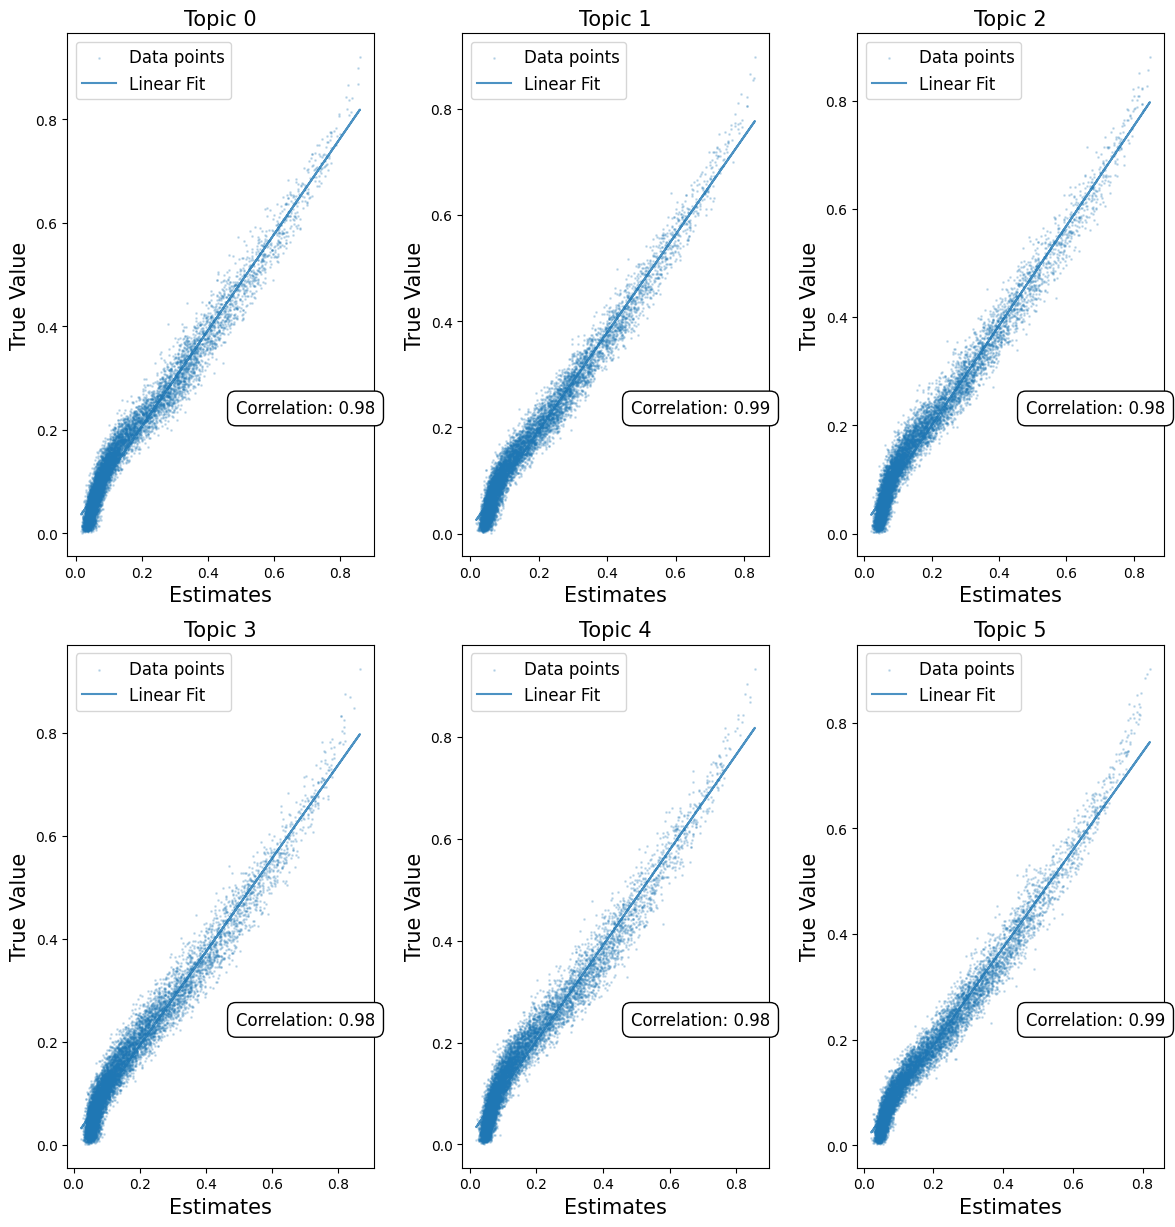

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Define the number of topics
num_topics = len(reanged_df_gtm.columns)  # Assuming each column corresponds to a topic

# Define grid dimensions: 2 figures per row
n_cols = 3
n_rows = (num_topics + 1) // 2  # This ensures you have enough rows to accommodate all topics

# Create subplots with the grid layout
fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 6*n_rows)) 

# Flatten the axs array to handle it as a 1D list
axs = axs.flatten()

for i in range(num_topics):  
    x = reanged_df_gtm['Topic{}'.format(i)]
    y = true_df['Topic{}'.format(i)]
    
    axs[i].scatter(x, y, label='Data points', s=1, alpha=0.2)
    coefficients = np.polyfit(x, y, 1)
    fit = np.poly1d(coefficients)
    axs[i].plot(x, fit(x), label='Linear Fit', alpha=0.8)
    axs[i].set_xlabel('Estimates', fontsize=15)
    axs[i].set_ylabel('True Value', fontsize=15)
    axs[i].set_title('Topic {}'.format(i), fontsize=15)
    axs[i].legend(fontsize=12)

    # Calculate correlation coefficient
    corr_coeff = np.corrcoef(x, y)[0, 1]
    # Add annotation
    axs[i].annotate(f'Correlation: {corr_coeff:.2f}', xy=(0.55, 0.3), xycoords='axes fraction',
                 fontsize=12, verticalalignment='top', horizontalalignment='left',
                 bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

# Hide any unused subplots if num_topics is odd
for j in range(num_topics, n_rows * n_cols):
    fig.delaxes(axs[j])

plt.tight_layout() 
plt.show()

In [6]:
# Estimate topic proportions and standard errors
means, stds = tm.get_doc_topic_distribution(full_dataset, num_samples=100, return_std=True)

coverage_per_topic = []
for i in range(num_topics):
    est_idx = corres_num_topic_dict_gtm_bis[i]  # estimated topic index that matches true topic i
    true_vals = true_df[f'Topic{i}'].values
    lower = means[:, est_idx] - 1.96 * stds[:, est_idx]
    upper = means[:, est_idx] + 1.96 * stds[:, est_idx]
    coverage = np.mean((true_vals >= lower) & (true_vals <= upper))
    coverage_per_topic.append(coverage)
    print(f"Aligned Topic {i} (est. Topic {est_idx}): 95% CI coverage = {coverage:.3f}")

Aligned Topic 0 (est. Topic 2): 95% CI coverage = 0.997
Aligned Topic 1 (est. Topic 5): 95% CI coverage = 1.000
Aligned Topic 2 (est. Topic 4): 95% CI coverage = 0.997
Aligned Topic 3 (est. Topic 0): 95% CI coverage = 0.998
Aligned Topic 4 (est. Topic 1): 95% CI coverage = 0.996
Aligned Topic 5 (est. Topic 3): 95% CI coverage = 0.999


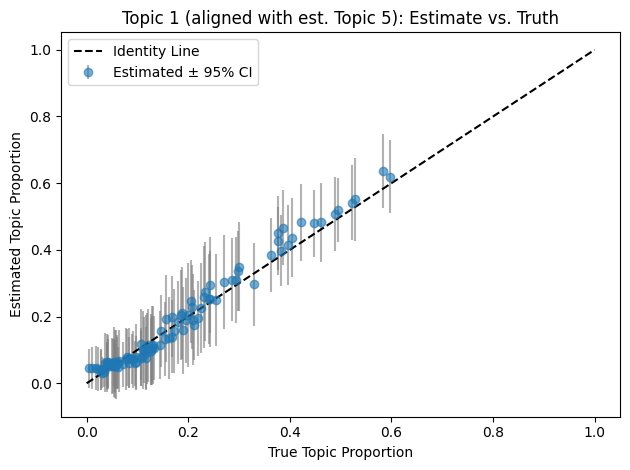

In [7]:
# Choose a topic for detailed visualization (e.g., Topic 0)
topic_idx = 1  # this is the true topic index
est_idx = corres_num_topic_dict_gtm_bis[topic_idx]  # corresponding estimated topic index

true_vals = true_df[f'Topic{topic_idx}'].values
est_vals = means[:, est_idx]
est_std = stds[:, est_idx]

# Subsample for visualization
N_plot = 100
indices = np.random.choice(len(true_vals), size=N_plot, replace=False)

plt.errorbar(
    x=true_vals[indices],
    y=est_vals[indices],
    yerr=1.96 * est_std[indices],
    fmt='o',
    ecolor='gray',
    alpha=0.6,
    label='Estimated ± 95% CI'
)
plt.plot([0, 1], [0, 1], 'k--', label='Identity Line')
plt.xlabel('True Topic Proportion')
plt.ylabel('Estimated Topic Proportion')
plt.title(f'Topic {topic_idx} (aligned with est. Topic {est_idx}): Estimate vs. Truth')
plt.legend()
plt.tight_layout()
plt.show()
